# Fandango Movie Ratings

FiveThirtyEight published an article regarding online movie rating aggregations, and how, in particular, Fandango inflate movie scores. It can be read [here](https://fivethirtyeight.com/features/fandango-movies-ratings/).

We will read the dataset and perform statistical analysis along the way.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress
%matplotlib inline
movies = pd.read_csv("data-sets/fandango_score_comparison.csv")
movies.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


# Statistical Exploration

Now that we have loaded the dataset, we can do some statistical analysis on the "ratings" columns. For this analysis, we will focus on `Fandango_Stars` and `Metacritic_norm_round`. How do these two rating sites differ when it comes to rating movies? 

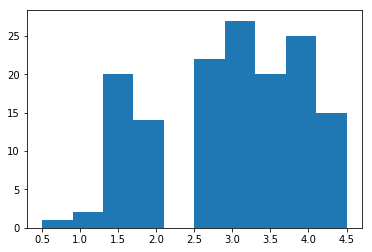

In [2]:
m_hist = plt.hist(movies["Metacritic_norm_round"])

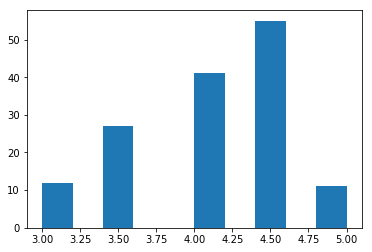

In [3]:
f_hist = plt.hist(movies["Fandango_Stars"])

After plotting two histograms, we can infer that Fandango does not rate any movie below 3.0. Also, Fandango aggregates their scores around 4.0 to 4.5. Compared to Fandango, Metacritic centers their scores around 3.0 to 3.5.  Let's dig a little deeper by checking the mean, median, and the standard deviation between the two. These will allow us to quantify the differences.

In [4]:
#Obtain the mean, median, and standard deviation and print out the results
f_mean = movies["Fandango_Stars"].mean()
m_mean = movies["Metacritic_norm_round"].mean()
f_median = movies["Fandango_Stars"].median()
m_median = movies["Metacritic_norm_round"].median()
f_std = movies["Fandango_Stars"].std()
m_std = movies["Metacritic_norm_round"].std()

print("Fandango_Stars - mean: {}".format(f_mean))
print("Metacritic_norm_round - mean: {}".format(m_mean))
print("Fandango_Stars - median: {}".format(f_median))
print("Metacritic_norm_round - median: {}".format(m_median))
print("Fandango_Stars - standard deviation: {}".format(f_std))
print("Metacritic_norm_round - standard deviation: {}".format(m_std))

Fandango_Stars - mean: 4.089041095890411
Metacritic_norm_round - mean: 2.9726027397260273
Fandango_Stars - median: 4.0
Metacritic_norm_round - median: 3.0
Fandango_Stars - standard deviation: 0.5403859779787333
Metacritic_norm_round - standard deviation: 0.9909605613743364


## Methodology Differences

It is probable that Fandango inflates their scores and is not transparent on their aggregate methodology. Metacritic publishes each rating and converts it into a scale out of 100. Information on Metacritic's method can is found [here](http://www.metacritic.com/about-metascores).

## By the Numbers

An interesting note is a comparison with the mean and median between Fandango and Metacritic. Note both of Fandango's mean and median are the same. The reason is due to the high ratings "dragging up the mean." In Metacritic's case, the median is slightly greater than the mean; a few lower reviews "dragged down the median."

Fandango ratings appear clustered between 3.0 and 5.0--and have small random values compared to Metacritic, which is between 0.0 to 5.0.

We can assert that Fandango has a higher rating than Metacritic. 

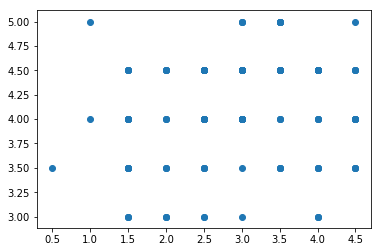

In [5]:
plt.scatter(movies["Metacritic_norm_round"], movies["Fandango_Stars"])

Several movies appear to have low reviews on Metacritic and high reviews on Fandango. Let's explore this further by finding the difference between the columns using the absolute value. 

In [6]:
#Assign a new table by subtracting both columns

movies["fm_diff"] = np.abs(movies["Metacritic_norm_round"] - movies["Fandango_Stars"])

In [7]:
#Sort the values
movies.sort_values(by="fm_diff", ascending=False).head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference,fm_diff
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.20,...,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5,4.0
85,Little Boy (2015),20,81,30,5.9,7.4,4.5,4.3,1.00,4.05,...,1.0,4.0,1.5,3.0,3.5,38,5927,811,0.2,3.0
47,Annie (2014),27,61,33,4.8,5.2,4.5,4.2,1.35,3.05,...,1.5,3.0,1.5,2.5,2.5,108,19222,6835,0.3,3.0
19,Pixels (2015),17,54,27,5.3,5.6,4.5,4.1,0.85,2.70,...,1.0,2.5,1.5,2.5,3.0,246,19521,3886,0.4,3.0
134,The Longest Ride (2015),31,73,33,4.8,7.2,4.5,4.5,1.55,3.65,...,1.5,3.5,1.5,2.5,3.5,49,25214,2603,0.0,3.0


In [8]:
#Correlation between Fandango_Stars and Metacritic_norm_round
r_value, p_value = pearsonr(movies["Fandango_Stars"], movies["Metacritic_norm_round"])
r_value

0.17844919073895918

The weak correlation between Fandango and Metacritic suggests that Fandango scores appear inflated and they are fundamentally different. The reason is unknown as to why Fandango inflates their scores overall. Maybe movie studios have a greater influence on Fandango than Metacritic?

In [9]:
#Predicting which movie got a 3.0 in Metacritic would be in Fandango
slope, intercept, r_value, p_value, std_err = linregress(movies["Metacritic_norm_round"], movies["Fandango_Stars"])
predict_3 = 3 * slope + intercept
predict_3

4.0917071528212041

In [10]:
#Let's do another prediction. 
#What movie that receive a 1.0 on Metacritic would look like on Fandango? What about 5.0?
predict_1 = 1 * slope + intercept
predict_5 = 5 * slope + intercept
print(predict_1)
print(predict_5)

3.89708499687
4.28632930877


## Graph the Results

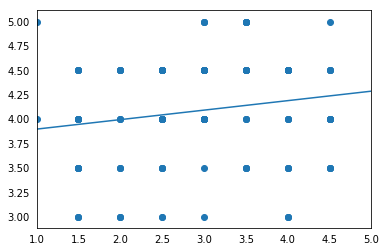

In [14]:
#Graph the Residuals
plt.scatter(movies["Metacritic_norm_round"], movies["Fandango_Stars"])
plt.plot([1.0,5.0], [predict_1, predict_5])
plt.xlim(1,5)
plt.tick_params(
    axis='both',
    which='both',
    left='off',
    bottom='off',
    right='off',
    top='off'
)
plt.show()

## Conclusion
We have looked at the dataset and use statistical analysis to compare movie ratings between Metacritic and Fandango. Over the course of the analysis, we used statistical methods to see if Fandango inflates their ratings. As such, based on the analysis, it is proportional that Fandango not only inflates their reviews but projects specific movies to a higher rating. 